In [826]:
import os
import mysql.connector
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

from matplotlib.legend import Legend

%matplotlib inline

In [287]:
user_name = os.environ.get('DB_USER')
password = os.environ.get('DB_PASSWORD')
DB_NAME = 'BacterialGrowth'

# Database functions

In [401]:
user_name = os.environ.get('DB_USER')
password = os.environ.get('DB_PASSWORD')

DB_NAME = 'BacterialGrowth'

def execute(phrase):
    """This function create a connection to the database and execute a command.
    :param phrase: str SQL sentence to execute
    :return: list of str received from the database after command execution.
    """
    try:
        cnx = mysql.connector.connect(user=user_name, password=password,host='localhost',database=DB_NAME)
        cnx.get_warnings = True
        cursor = cnx.cursor()
        cursor.execute(phrase)
        res = []
        for row in cursor:
            res.append(row)

        warnings = cursor.fetchwarnings()
        if warnings: 
            for i in range(len(warnings)):
                print("\t ** Warning - "+warnings[i][2])
        cursor.close()
        cnx.commit()
        cnx.close()
        return res
    except mysql.connector.Error as err:
        print("Something went wrong: {}".format(err))
        print(phrase)

def addRecord(table, args):
    """ 
    This function adds a new entry into the indicated table.

    :table: table of the DB
    :args: dictionary with the data to insert
    :return: id of the inserted record
    """
    # Insert into table
    fields, values = getFieldsValues(args)
    phrase = "INSERT IGNORE INTO " +table+" "+fields+" VALUES "+values
    res = execute(phrase)
    
    # Get the name of the primary key field
    phrase = "SHOW KEYS FROM "+table+" WHERE Key_name = 'PRIMARY'"
    res = execute(phrase)
    pk = res[0][4]
    
    # Get the value of the primary key (this will return the value both if it was inserted or ignored)
    where_clause = getWhereClause(args)
    phrase = "SELECT "+pk+" FROM "+table+" "+where_clause
    res = execute(phrase)
    last_id = res[0][0]
    
    return last_id

def countRecords(table, args):
    phrase = "SELECT COUNT(*) FROM " + table
    if args:
        where_clause = getWhereClause(args)
        phrase = phrase+" "+where_clause
    res = execute(phrase)
    return res

def getAllRecords(table, **args):
    phrase = "SELECT * FROM " + table
    if args:
        where_clause = getWhereClause(args)
        phrase = phrase+" "+where_clause
    res = execute(phrase)
    return res

def getFiles(field, args):
    where_clause = getWhereClause(args)
    phrase = "SELECT "+field+" FROM TechnicalReplicate "+where_clause
    res = execute(phrase)
    return res

def getRecords(table, field, args):
    where_clause = getWhereClause(args)
    phrase = "SELECT "+field+" FROM "+table+" "+where_clause
    res = execute(phrase)
    return res

# Utils functions

In [524]:
def isDir(string):
    '''
    This function checks if the given string is a directory path
    '''
    if os.path.isdir(string):
        return string
    else:
        raise NotADirectoryError(string)
    
def isFile(string):
    '''
    This function checks if the given string is a directory path
    '''
    if os.path.isfile(string):
        return string
    else:
        a = 0
        # Put warning or something here

def findOccurrences(string, ch):
    '''
    This function returns a list with all the positions of the string that contain the character ch
    '''
    return [i for i, letter in enumerate(string) if letter == ch]


def getMatchingList (regex, lst):
    '''
    This function takes a regex expression and returns a list with all the matching words in the given lst
    '''
    res = []
    for word in lst:
        if regex.findall(word):
            res.append(word)
    return res

def saveFile(data, path):
    if len(data.columns) > 1:
        data.to_csv(path, sep=" ", index=False)


def getIntersectionColumns(df, columns):
    res = df[df.columns.intersection(columns)]
    return res

def getFieldsValues(args):
    fields = "("
    values = "("
    for key, val in args.items():
        fields = fields + key + ','
        values = values + "'" +str(val) + "',"
    fields = fields[:-1] + ')'
    values = values[:-1] + ')'
    return [fields, values]

def getWhereClause(args):
    if len(args) == 0:
        clause = ''
    else:
        clause = "WHERE ("
        for key, val in args.items():
            if val != 'null':
                clause = clause + key + "= '" + str(val) + "' AND "
            if val == 'null':
                clause = clause + key + " IS NULL AND "
        clause = clause[:-5] + ')'
    return clause
    
def getMeanStd(records, header):
    df = pd.DataFrame(columns=range(len(records)+1)) #Each column will be the value of each record
    # Fill the df parsing all the records' files
    for i, record in enumerate(records, 1):
        record_df = pd.read_csv(record[0], sep=" ")
        df.iloc[:,i] = record_df[header]

    # Calculate and keep mean and std
    df_res = pd.DataFrame(columns=range(3))
    df_res.set_axis(['time', 'mean', 'std'], axis='columns', inplace=True)
    df_res['time'] = record_df['time']
    df_res['mean'] = df.iloc[:,1:].mean(axis=1, numeric_only=True)
    df_res['std'] = df.iloc[:,1:].std(axis=1, numeric_only=True)
    
    return df_res


# User input functions

In [403]:
def chooseStudy():
    studies = getAllRecords('Study')

    if len(studies) == 0:
        print('\n\tERROR: There are no studies yet in the DB')
        print('\t- Create an study using the flag -s.\n')
        exit()
    
    studies_table = PrettyTable()
    studies_table.field_names = ["ID", "Name", "Description"]
    studies_table.align["Name"] = "l"
    studies_table.align["Description"] = "l"

    studies_id = []
    for study in studies:
        studies_table.add_row(study)
        studies_id.append(str(study[0]))
    
    print(studies_table)

    study_id = input("-- Choose study ID: ")
    if study_id not in studies_id:
        print('\n\tERROR: You have not selected a valid study ID. Check the table above.\n')
        exit()
    
    return study_id

def chooseExperiment(study_id):
    experiments = getAllRecords('Experiment', studyId=study_id)
     
    if len(experiments) == 0:
        print('\n\tERROR: There are no experiments with id {}:'.format(study_id))
        print('\t- Select another study ID\n\t- Create experiments with this study ID before introducing perturbations/replicates files into it.\n')
        exit()

    experiments_table = PrettyTable()
    experiments_table.field_names = ["ID","Name","Study ID","Precult","Reactor","Plate ID","Column","Row","Media","Blank","inoculumConc","inoculumVol","initPh","initTemp","carbonSource","antibiotic","Description"]
    
    experiments_id = []
    for experiment in experiments:
        experiments_table.add_row(experiment)
        experiments_id.append(str(experiment[0]))
    
    print(experiments_table)    

    experiment_id = input("-- Choose experiment ID: ")
    if experiment_id not in experiments_id:
        print('\n\tERROR: You have not selected a valid experiment ID. Check the table above.\n')
        exit()

    return experiment_id

def choosePerturbation(experiment_id):
    perturbations = getAllRecords('Perturbation', experimentId=experiment_id)

    if len(perturbations) == 0:
        print('\n\tERROR: There are no perturbations with experiment id {}:'.format(experiment_id))
        print('\t- Select another experiment ID\n\t- Create perturbation with this experiment ID before introducing replicates files into it.\n')
        exit()

    perturbations_table = PrettyTable()
    perturbations_table.field_names = ["ID","Experiment ID","Property","New Value","Starting time (min)","Ending time (min)","Description"]
    
    perturbations_id = []
    for perturbation in perturbations:
        perturbations_table.add_row(perturbation)
        perturbations_id.append(str(perturbation[0]))
    
    print(perturbations_table)    

    perturbation_id = input("-- Choose perturbation ID: ")
    if perturbation_id not in perturbations_id:
        print('\n\tERROR: You have not selected a valid perturbation ID. Check the table above.\n')
        exit()

    return perturbation_id

def chooseReplicate(experiment_id, perturbation_id):
    if perturbation_id == None:
        id = experiment_id
        replicates = getAllRecords('TechnicalReplicate', experimentId=id)
        if len(replicates) == 0:
            print('\n\tERROR: There are no replicates with experiment_id {}'.format(id))
            print('\t- Select another experiment ID\n\t- Create perturbation with this experiment ID before introducing replicates files into it.\n')
            exit()

    else:
        id = perturbation_id
        replicates = getAllRecords('TechnicalReplicate', perturbationId=id)
        if len(replicates) == 0:
            print('\n\tERROR: There are no replicates with perturbation_id {}'.format(id))
            print('\t- Select another experiment ID\n\t- Create perturbation with this experiment ID before introducing replicates files into it.\n')
            exit()

    replicates_table = PrettyTable()
    replicates_table.field_names = ["ID","Experiment ID","Perturbation ID"]
    
    replicates_id = []
    for replicate in replicates:
        print(replicate[0:3])
        replicates_table.add_row(replicate[0:3])
        replicates_id.append(str(replicate[0]))
    
    print(replicates_table)    

    replicate_id = input("-- Choose replicate ID: ")
    if replicate_id not in replicates_id:
        print('\n\tERROR: You have not selected a valid replicate ID. Check the table above.\n')
        exit()

    return replicate_id

In [555]:
def getMeanStd(files, regex=''):
    '''
    This function gets a df and the columns (regex or all columns) in which mean and std are going to be calculated
    For each header, 
    '''
    df = pd.read_csv(files[0][0], sep=" ")
    
    if regex != '':
        headers = getMatchingList(regex, df)
    else:
        headers = df.columns
    
    msd = pd.DataFrame(columns=range(1))
    msd.set_axis(['time'], axis='columns', inplace=True)
    msd['time'] = df['time']
    
    for header in headers:
        if header != 'time':
            df_header = pd.DataFrame(columns=range(len(files)+1)) #Each column will be the value from each file

            # Fill the df parsing all the records' files
            for i, file in enumerate(files, 1):
                file_df = pd.read_csv(file[0], sep=" ")
                df_header.iloc[:,i] = file_df[header]

            # Calculate and keep mean and std
            msd_header = pd.DataFrame(columns=range(3))
            msd_header.set_axis(['time', header+'_mean', header+'_std'], axis='columns', inplace=True)
            msd_header['time'] = file_df['time']
            msd_header[header+'_mean'] = df_header.iloc[:,1:].mean(axis=1, numeric_only=True)
            msd_header[header+'_std'] = df_header.iloc[:,1:].std(axis=1, numeric_only=True)

            msd = pd.merge(msd, msd_header, on='time')
    
    return msd

# General functions

In [981]:
def plotDf(df, ax, style_count=0):
    cmap = plt.get_cmap(name='tab10')
    styles = ['-', '--', '-.', ':', '-x', '-o', '-<', '->']

    
    msd_regex = re.compile(r'.*mean.* | .*std.*', flags=re.I | re.X)
    
    if len(getMatchingList(msd_regex, df)) > 0:
        vec = range(1,len(df.columns),2)
        for i in vec:
            plot = ax.errorbar(df.iloc[:,0], df.iloc[:,i], yerr = df.iloc[:,i+1], fmt=styles[style_count], color = cmap(i-1), label=df.columns[i][:-5])
            #plot.set_linestyle(styles[style_count])
    else:
        vec = range(1,len(df.columns))
        for i in vec:
            plot = ax.plot(df.iloc[:,0], df.iloc[:,i], linestyle=styles[style_count], color = cmap(i-1), label=df.columns[i])
    return plot, vec

In [991]:
def plotOneReplicate(files, regex='', db_field=''):
    df = pd.read_csv(files[0][0], sep=" ")
    
    if regex != '':
        headers = getMatchingList(regex, df)
    else:
        headers = df.columns
    
    data = getIntersectionColumns(df, headers)
            
    # plot
    fig = plt.figure()
    ax = fig.add_subplot()
    if len(data.columns)>1: 
        plot, vec = plotDf(data, ax)
    else: 
        plot = plt.close()
        vec = range(0,0,1)
    
    # Legend: =========================================================
    if plot != None:
        handles, labels = ax.get_legend_handles_labels()
        ax.legend(labels, loc='upper right')
    # =================================================================
    
    ax.set_xlabel('time')
    ax.set_ylabel(db_field[:-4])
    plt.show()
    
    return plot, vec

In [969]:
def plotSetReplicates(files, regex, ax, count):
    data = getMeanStd(files, regex)
        
    if len(data.columns)>1: 
        plot, vec = plotDf(data, ax, count)
    else: 
        plot = plt.close()
        vec = range(0,0,1)
    
    return plot, vec

In [1011]:
def plotExperimentPerturbation(args, regex='', db_field=''):
    
    label_ids = []
    
    if 'experimentId' in args:
        exp_with_null = countRecords('TechnicalReplicate', {'experimentId': args['experimentId']})[0][0]
        exp_without_null = countRecords('TechnicalReplicate', {'experimentId': args['experimentId'], 'perturbationId': 'null'})[0][0]
    else:
        exp_with_null = 0
        exp_without_null = 0
    
    if exp_with_null != exp_without_null and exp_with_null > 0 and exp_without_null > 0:
        perturbation_ids = getRecords('Perturbation', 'perturbationId', args)
        
        # plot
        cnt = 0
        fig = plt.figure()
        ax = fig.add_subplot()
        
        args2 = args.copy()
        args2['perturbationId'] = 'null'
        files = getFiles(db_field, args2)
        plot, vec = plotSetReplicates(files, regex, ax, cnt)
        cnt = cnt + 1
        
        label = 'Experiment id ' + args['experimentId']
        label_ids.append(label)
        
        
        for perturbation_id in perturbation_ids:
            files = getFiles(db_field, {'perturbationId': perturbation_id[0]})
            plot, vec = plotSetReplicates(files, regex, ax, cnt)
            cnt = cnt + 1
            
            label = 'Perturbation id ' + perturbation_id[0]
            label_ids.append(label)
            
            
        # Legend: =========================================================
        if plot != None:
            handles, labels = ax.get_legend_handles_labels()
            legend1 = ax.legend(labels[0:len([*vec])], loc='upper right')
            legend2 = getExperimentLegend(ax, handles, label_ids, vec)

            ax.add_artist(legend2)
        # =================================================================
        ax.set_xlabel('time')
        ax.set_ylabel(db_field[:-4])
        plt.show()
        
    else:
        perturbation_ids = getRecords('Perturbation', 'perturbationId', args)
        
        if len(perturbation_ids) == 0:
            files = getFiles(db_field, args)
            
            cnt = 0
            fig = plt.figure()
            ax = fig.add_subplot()
            
            plot, vec = plotSetReplicates(files, regex, ax, cnt)
            cnt = cnt + 1
            
            label = 'Experiment id ' + args['experimentId']
            label_ids.append(label)
            
            # Legend: =========================================================
            if plot != None:
                handles, labels = ax.get_legend_handles_labels()
                legend1 = ax.legend(labels[0:len([*vec])], loc='upper right')
                legend2 = getExperimentLegend(ax, handles, label_ids, vec)

                ax.add_artist(legend2)
            # =================================================================
            ax.set_xlabel('time')
            ax.set_ylabel(db_field[:-4])
            plt.show()
            
        else:
            cnt = 0
            fig = plt.figure()
            ax = fig.add_subplot()
            
            for perturbation_id in perturbation_ids:
                files = getFiles(db_field, {'perturbationId': perturbation_id[0]})
                plot, vec = plotSetReplicates(files, regex, ax, cnt)
                cnt = cnt + 1
                
                label = 'Perturbation id ' + perturbation_id[0]
                label_ids.append(label)
            
            # Legend: =========================================================
            if plot != None:
                handles, labels = ax.get_legend_handles_labels()
                legend1 = ax.legend(labels[0:len([*vec])], loc='upper right')
                legend2 = getExperimentLegend(ax, handles, label_ids, vec)

                ax.add_artist(legend2)
            # =================================================================
            
            ax.set_xlabel('time')
            ax.set_ylabel(db_field[:-4])
            plt.show()
            

In [1012]:
def getExperimentLegend(ax, handles, labels, vec):
    vec1 = [*range(0,len(labels))]
    vec2 = [x * len(vec) for x in vec1]
    new_handles = [handles[i] for i in vec2]
    leg = Legend(ax, new_handles, labels, frameon=False, bbox_to_anchor=(1.04, 1), loc='lower right')
    return leg

In [1013]:
abundance_options = ['od', 'counts', 'qpcr', 'rnaseq']
od_regex = re.compile(r'.*time.* | .*OD.*', flags=re.I | re.X)
counts_regex = re.compile(r'.*time.* | .*count.*', flags=re.I | re.X)
qpcr_regex = re.compile(r'.*time.* | .*qpcr.*', flags=re.I | re.X)
rnaseq_regex = re.compile(r'.*time.* | .*rna.*', flags=re.I | re.X)

def plotAbundances(files, args):
    if len(files) == 1:
        for opt in abundance_options:
            regex = globals()['%s_regex' % opt]
            plot = plotOneReplicate(files, regex, 'abundanceFile')
            plt.show()
            
    elif len(files) > 1:
        for opt in abundance_options:
            regex = globals()['%s_regex' % opt]
            plotExperimentPerturbation(args, regex, 'abundanceFile')
            
                
    
def plotMetabolites(files, args):
    if len(files) == 1:
        plotOneReplicate(files, '', 'metabolitesFile')
        plt.show()
            
    elif len(files) > 1:
        plotExperimentPerturbation(args, '', 'metabolitesFile')
        plt.show()
    
    
def plotPh(files, args):
    if len(files) == 1:
        plotOneReplicate(files, '', 'phFile')
        plt.show()
            
    elif len(files) > 1:
        plotExperimentPerturbation(args, '', 'phFile')
        plt.show()

# User input to get the args

Plotting options: 
* Plot one replicate -> the plot is a simple line without mean and standar deviation as it only represents one set of data poitns
* Plot one perturbation --> the plot is a single line in the mean points over all the technical replicates. It contains the standar deviation values.
* Plot one experiment --> the plot contains multiple lines. Each of them represents one experiment and/or perturbations of that experiment. Each line is the mean and standard deviation over the technical replicates. Options:
 
 a) one experiment without pertubations -> one line
 
 b) one experiment with only data on the perturbations -> one line per perturbation
 
 c) one experiment with data both from the experiment and the perturbations -> one line per perturbation and another from the experiment data

In [1018]:
# Get from other notebook with the user input
args = {'replicateId': '101.1_1'}
args = {'perturbationId': '101.1'}
args = {'experimentId': '103'}

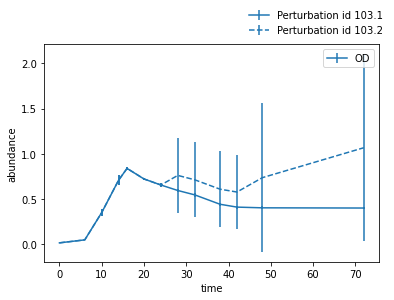

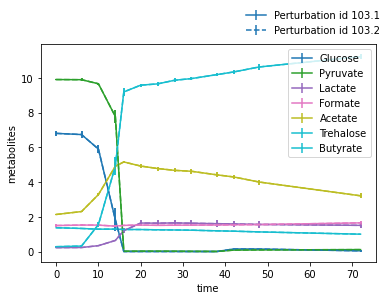

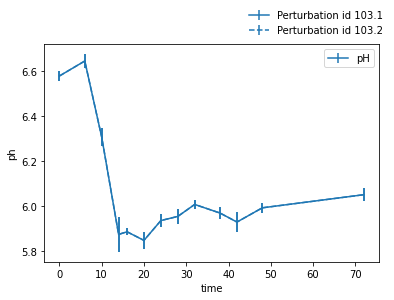

In [1019]:
fields = ['abundance', 'metabolites', 'ph']
#fields = ['ph']

if 'abundance' in fields:
    files = getFiles('abundanceFile', args)
    plotAbundances(files, args)
   
if 'metabolites' in fields:
    files = getFiles('metabolitesFile', args)
    plotMetabolites(files, args)

if 'ph' in fields:
    files = getFiles('phFile', args)
    plotPh(files, args)

# Plot trials

## Plot one replicate

## Plot several replicates from the same perturbation

### Separated values

## Plot several replicates from the same perturbation

### Mean and standard deviation values

## Plot several perturbations from the same experiment

## TO DO:

Pass color vector or something to differentiate experiments